#1. 데이터 불러오기

In [31]:
# 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall


import warnings
warnings.filterwarnings("ignore")

In [33]:
train = keras.utils.image_dataset_from_directory("/content/drive/MyDrive/train/train")
test = keras.utils.image_dataset_from_directory("/content/drive/MyDrive/test/test")
val = keras.utils.image_dataset_from_directory("/content/drive/MyDrive/val/val")

Found 5216 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
Found 16 files belonging to 2 classes.


#2. 전처리
데이터 확인, 정규화, 시각화

In [34]:
print(train.class_names)

['NORMAL', 'PNEUMONIA']


In [35]:
batch = train.as_numpy_iterator().next()

In [36]:
print(batch)

(array([[[[9.62988281e+00, 9.62988281e+00, 9.62988281e+00],
         [2.33789062e+00, 2.33789062e+00, 2.33789062e+00],
         [3.98437500e+01, 3.98437500e+01, 3.98437500e+01],
         ...,
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

        [[3.14648438e+00, 3.14648438e+00, 3.14648438e+00],
         [8.93554688e-01, 8.93554688e-01, 8.93554688e-01],
         [4.68750000e-01, 4.68750000e-01, 4.68750000e-01],
         ...,
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

        [[5.36767578e+01, 5.36767578e+01, 5.36767578e+01],
         [1.46484375e-01, 1.46484375e-01, 1.46484375e-01],
         [4.61425781e+00, 4.61425781e+00, 4.61425781e+00],
         ...,
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         

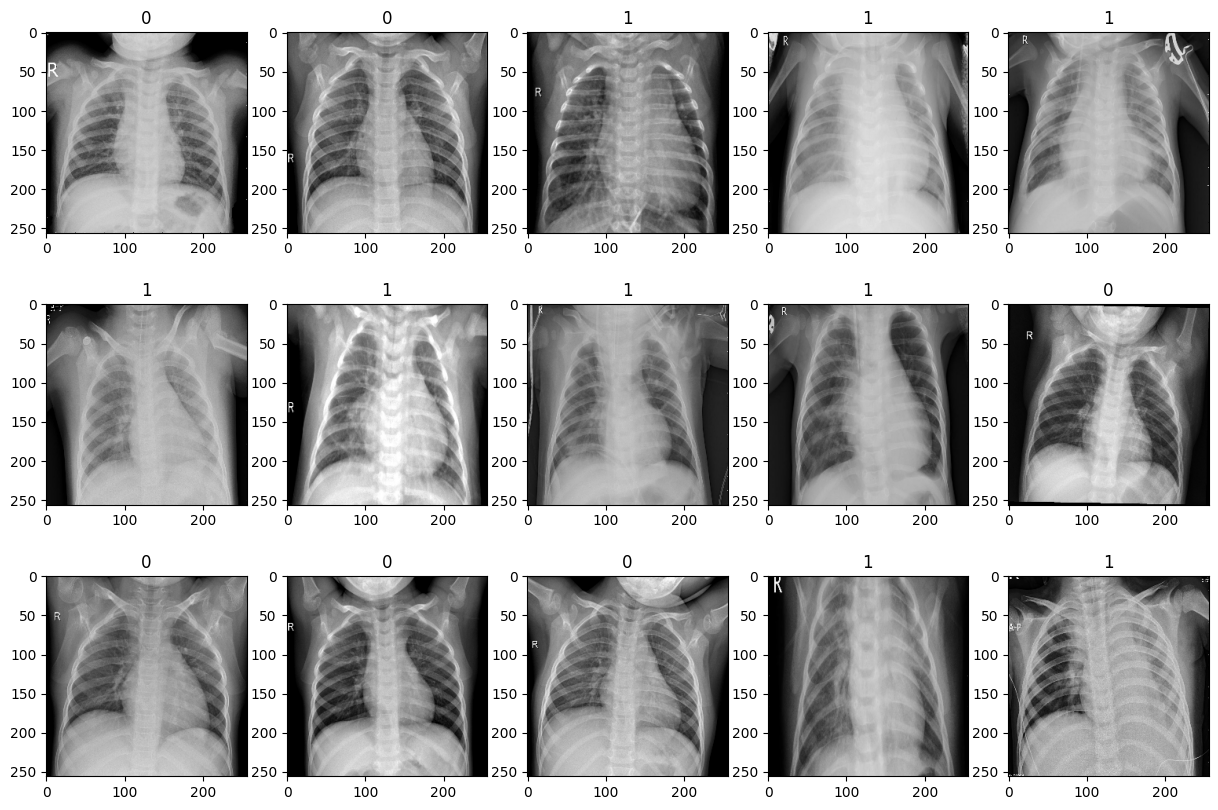

In [37]:
fig, ax = plt.subplots(3, 5, figsize=(15,10))
ax = ax.flatten()
for idx, img in enumerate(batch[0][:15]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [38]:
#정규화
train = train.map(lambda x, y:(x/255, y))
test = test.map(lambda x, y:(x/255, y))
val = val.map(lambda x, y:(x/255, y))

In [39]:
batch = train.as_numpy_iterator().next()

In [40]:
print(batch)

(array([[[[0.11464461, 0.11464461, 0.11464461],
         [0.14117648, 0.14117648, 0.14117648],
         [0.14050245, 0.14050245, 0.14050245],
         ...,
         [0.10980392, 0.10980392, 0.10980392],
         [0.10980392, 0.10980392, 0.10980392],
         [0.10588235, 0.10588235, 0.10588235]],

        [[0.12156863, 0.12156863, 0.12156863],
         [0.12120098, 0.12120098, 0.12120098],
         [0.13958333, 0.13958333, 0.13958333],
         ...,
         [0.10980392, 0.10980392, 0.10980392],
         [0.10588235, 0.10588235, 0.10588235],
         [0.10588235, 0.10588235, 0.10588235]],

        [[0.11464461, 0.11464461, 0.11464461],
         [0.12156863, 0.12156863, 0.12156863],
         [0.12722982, 0.12722982, 0.12722982],
         ...,
         [0.10588235, 0.10588235, 0.10588235],
         [0.10588235, 0.10588235, 0.10588235],
         [0.10037243, 0.10037243, 0.10037243]],

        ...,

        [[0.11262733, 0.11262733, 0.11262733],
         [0.14431584, 0.14431584, 0.14431584

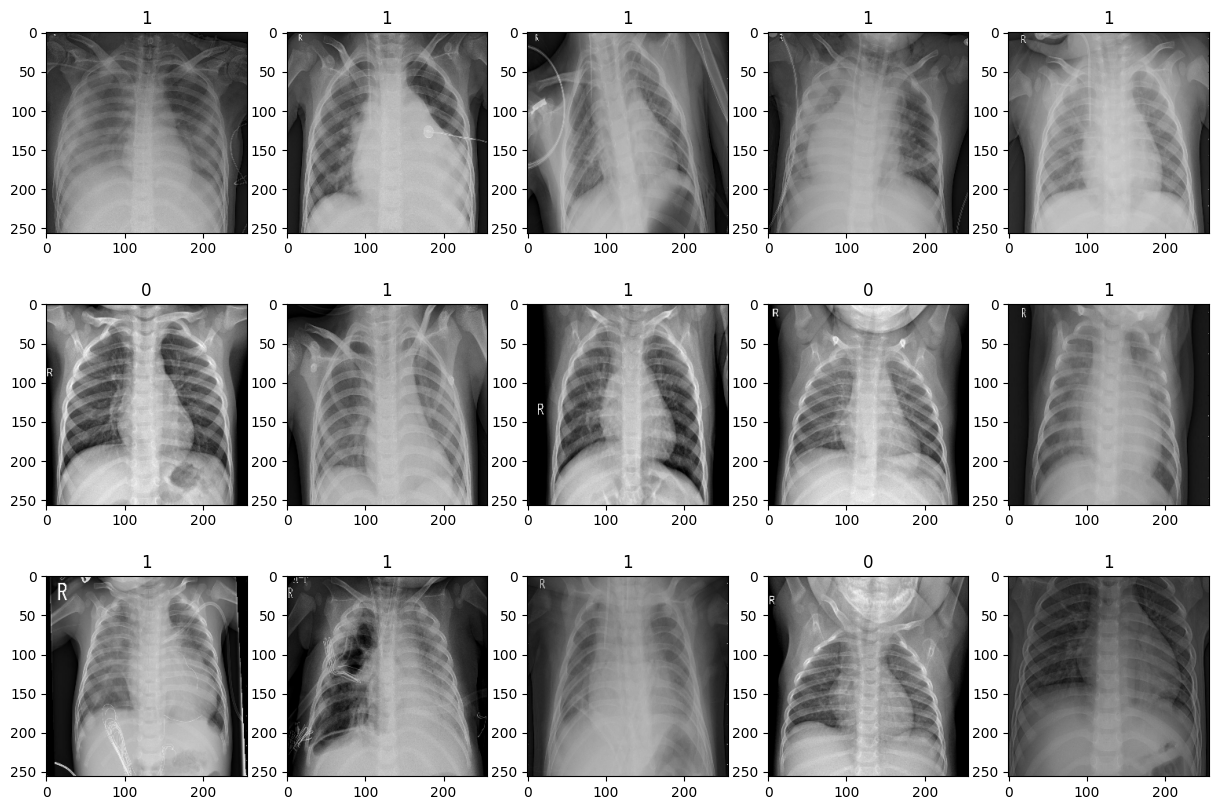

In [41]:
fig, ax = plt.subplots(3, 5, figsize=(15,10))
ax = ax.flatten()
for idx, img in enumerate(batch[0][:15]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

#3. 모델생성_1
이진 헤드만 학습 (백본 동결, learning rate=0.001)

In [42]:
from tensorflow.keras.applications import resnet50,ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import models, layers, optimizers
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report

In [43]:
# 사전학습 백본 (top 제거, 동결)
base = ResNet50(weights='imagenet', include_top=False, input_shape=(256,256,3))
base.trainable = False

In [44]:
#이진 분류 헤드 추가
finetune_model = models.Sequential([
    layers.Input(shape=(256, 256, 3)),
    layers.Lambda(lambda z: resnet50.preprocess_input(z * 255.0)),  # 현재 train/val/test가 x/255로 0~1이므로, 255를 곱해 원래 스케일로 되돌린 뒤 preprocess_input
    base,
    layers.GlobalAveragePooling2D(),      # Flatten 대신 권장
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])
finetune_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda_1 (Lambda)               │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 8, 8, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,718,913 (90.48 MB)

 Trainable params: 131,201 (512.50 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [45]:
#모델 컴파일
finetune_model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [46]:
#모델 학습
history1 = finetune_model.fit(
    train,
    epochs=50,
    validation_data=val,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 62s 309ms/step - accuracy: 0.8882 - loss: 0.2740 - val_accuracy: 0.8750 - val_loss: 0.2584
Epoch 2/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 47s 285ms/step - accuracy: 0.9582 - loss: 0.1043 - val_accuracy: 0.9375 - val_loss: 0.3190
Epoch 3/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 48s 294ms/step - accuracy: 0.9646 - loss: 0.0905 - val_accuracy: 0.9375 - val_loss: 0.1710
Epoch 4/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 47s 287ms/step - accuracy: 0.9740 - loss: 0.0764 - val_accuracy: 0.8750 - val_loss: 0.2336
Epoch 5/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 48s 294ms/step - accuracy: 0.9770 - loss: 0.0677 - val_accuracy: 0.9375 - val_loss: 0.1694
Epoch 6/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 47s 286ms/step - accuracy: 0.9776 - loss: 0.0617 - val_accuracy: 0.8125 - val_loss: 0.2559
Epoch 7/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 48s 293ms/step - accuracy: 0.9833 - loss: 0.0475 - val_accuracy: 0.8750 - val_loss: 0.1711
Epoch 8/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 46s 284ms/step - accuracy: 0.9823 - loss: 0

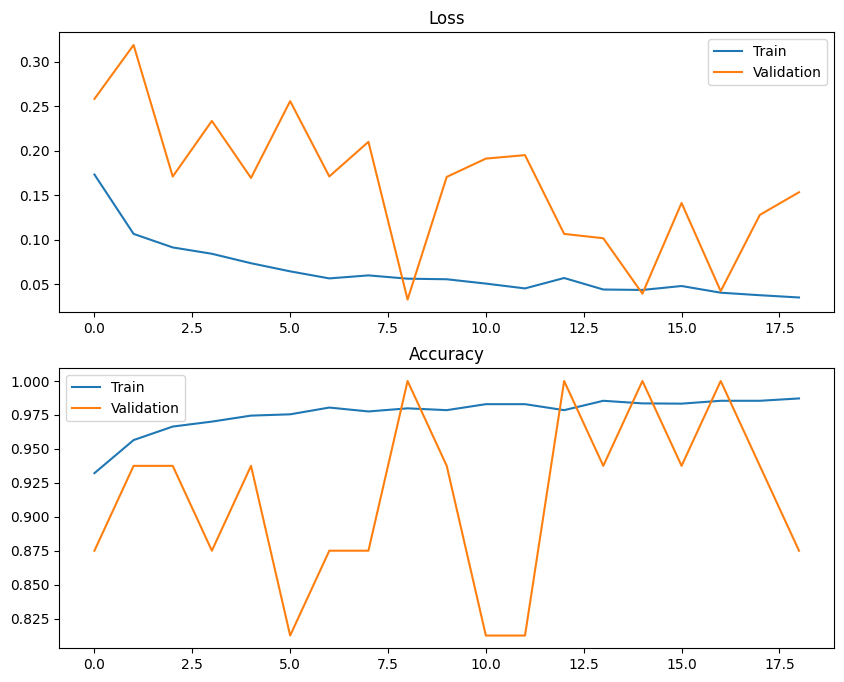

In [47]:
fig, ax = plt.subplots(2, 1, figsize=(10,8))

ax[0].plot(history1.history["loss"], label="Train")
ax[0].plot(history1.history["val_loss"], label="Validation")
ax[0].title.set_text("Loss")
ax[0].legend()

ax[1].plot(history1.history["accuracy"], label="Train")
ax[1].plot(history1.history["val_accuracy"], label="Validation")
ax[1].title.set_text("Accuracy")
ax[1].legend()

plt.show()

In [48]:
bin_acc = BinaryAccuracy()
recall = Recall()
precision = Precision()

for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = finetune_model.predict(X)
    bin_acc.update_state(y, yhat)
    recall.update_state(y, yhat)
    precision.update_state(y, yhat)

print("Accuracy:", bin_acc.result().numpy(), "\nRecall:", recall.result().numpy(), "\nPrecision:", precision.result().numpy())

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Accuracy: 0.8317308 
Recall: 0.99230766 
Precision: 0.79141104


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


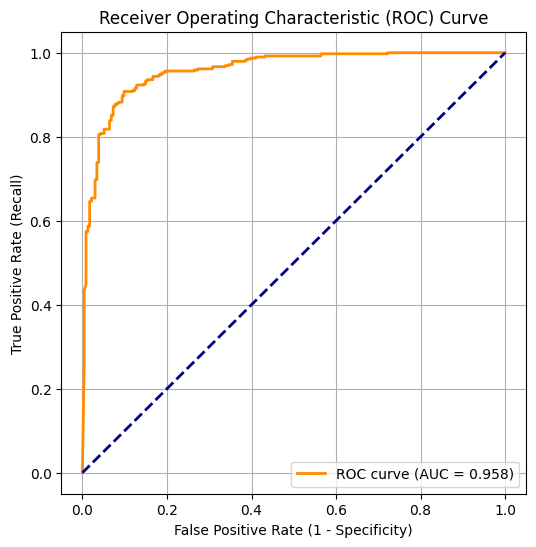

In [49]:
# 테스트셋 예측 확률 구하기
y_true = []
y_pred = []

for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = finetune_model.predict(X)
    y_true.extend(y)
    y_pred.extend(yhat)

# ROC curve 계산
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_pred)

# 그래프
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # 기준선
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [50]:
#AUC/혼동행렬/클래스리포트 추가
y_true2, y_pred2 = [], []
for X, y in test.as_numpy_iterator():
    yhat = finetune_model.predict(X, verbose=0).ravel()
    y_true2.extend(y)      # 라벨
    y_pred2.extend(yhat)   # 확률

y_true2 = np.array(y_true2).ravel().astype(int)
y_pred2 = np.array(y_pred2).ravel()

auc = roc_auc_score(y_true2, y_pred2)
preds = (y_pred2 >= 0.5).astype(int)

cm = confusion_matrix(y_true2, preds)
tn, fp, fn, tp = cm.ravel()

sensitivity = tp / (tp + fn)        # 민감도 (Sensitivity=Recall)
specificity = tn / (tn + fp)        # 특이도 (Specificity)

print("Confusion Matrix [[TN FP],[FN TP]]:\n", cm)
print(classification_report(y_true2, preds, target_names=["Normal","Pneumonia"]))
print(f"AUC: {auc:.3f}")
print(f"Sensitivity (Recall): {sensitivity:.3f}")
print(f"Specificity: {specificity:.3f}")

Confusion Matrix [[TN FP],[FN TP]]:
 [[132 102]
 [  3 387]]
              precision    recall  f1-score   support

      Normal       0.98      0.56      0.72       234
   Pneumonia       0.79      0.99      0.88       390

    accuracy                           0.83       624
   macro avg       0.88      0.78      0.80       624
weighted avg       0.86      0.83      0.82       624

AUC: 0.958
Sensitivity (Recall): 0.992
Specificity: 0.564


#4. 모델생성_2
상위 블록만 해제 후 파인 튜닝 (learning rate=> 더 작게)

In [51]:
# 2단계: 상위 블록(block5_conv*)만 훈련 가능하게 풀기
for layer in base.layers:
    if layer.name.startswith('conv5_'):
        layer.trainable = True
    else:
        layer.trainable = False

# 학습률을 더 작게
finetune_model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.Adam(learning_rate=1e-5),
    metrics=['accuracy']
)

# 다시 학습 (fine-tuning)
history2 = finetune_model.fit(
    train,
    epochs=30,
    validation_data=val,
    validation_steps=10,
    callbacks=[early_stopping]
)

Epoch 1/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 72s 321ms/step - accuracy: 0.9401 - loss: 0.1491 - val_accuracy: 0.9375 - val_loss: 0.1515
Epoch 2/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 48s 291ms/step - accuracy: 0.9902 - loss: 0.0321 - val_accuracy: 0.9375 - val_loss: 0.2066
Epoch 3/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 49s 301ms/step - accuracy: 0.9963 - loss: 0.0173 - val_accuracy: 0.9375 - val_loss: 0.2679
Epoch 4/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 81s 293ms/step - accuracy: 0.9978 - loss: 0.0114 - val_accuracy: 0.9375 - val_loss: 0.1297
Epoch 5/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 83s 301ms/step - accuracy: 0.9995 - loss: 0.0061 - val_accuracy: 0.8750 - val_loss: 0.1863
Epoch 6/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 48s 294ms/step - accuracy: 0.9990 - loss: 0.0066 - val_accuracy: 0.9375 - val_loss: 0.1614
Epoch 7/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 94s 371ms/step - accuracy: 0.9991 - loss: 0.0049 - val_accuracy: 0.9375 - val_loss: 0.1286
Epoch 8/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 48s 293ms/step - accuracy: 0.9992 - loss: 0

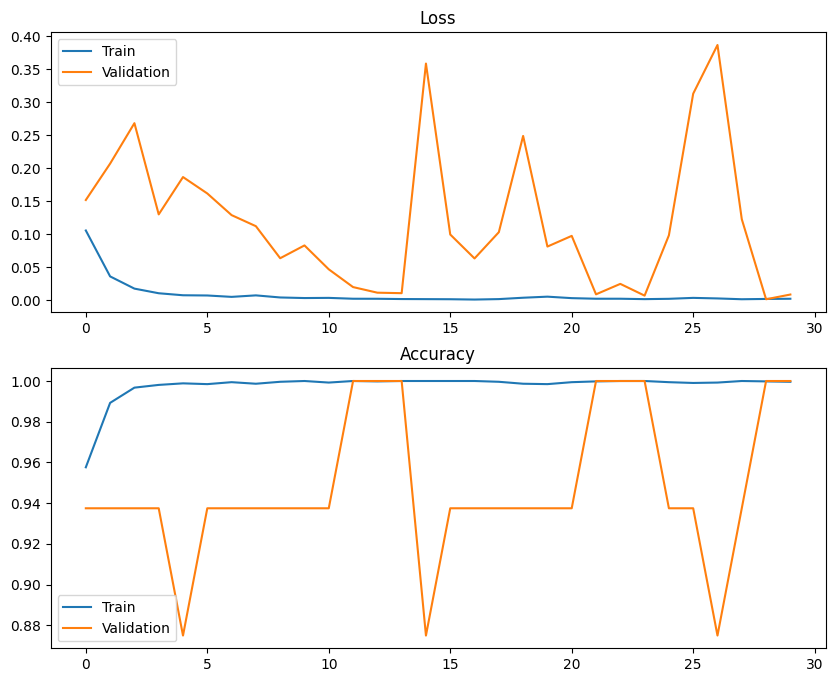

In [52]:
fig, ax = plt.subplots(2, 1, figsize=(10,8))

ax[0].plot(history2.history["loss"], label="Train")
ax[0].plot(history2.history["val_loss"], label="Validation")
ax[0].title.set_text("Loss")
ax[0].legend()

ax[1].plot(history2.history["accuracy"], label="Train")
ax[1].plot(history2.history["val_accuracy"], label="Validation")
ax[1].title.set_text("Accuracy")
ax[1].legend()

plt.show()

In [53]:
# 평가용 메트릭 초기화
bin_acc = BinaryAccuracy()
recall = Recall()
precision = Precision()

# test 데이터셋으로 계산
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = finetune_model.predict(X, verbose=0)
    bin_acc.update_state(y, yhat)
    recall.update_state(y, yhat)
    precision.update_state(y, yhat)

print("Fine-tuned model (history2) metrics")
print(f"Accuracy : {bin_acc.result().numpy():.3f}")
print(f"Recall (Sensitivity): {recall.result().numpy():.3f}")
print(f"Precision: {precision.result().numpy():.3f}")


Fine-tuned model (history2) metrics
Accuracy : 0.853
Recall (Sensitivity): 0.990
Precision: 0.814


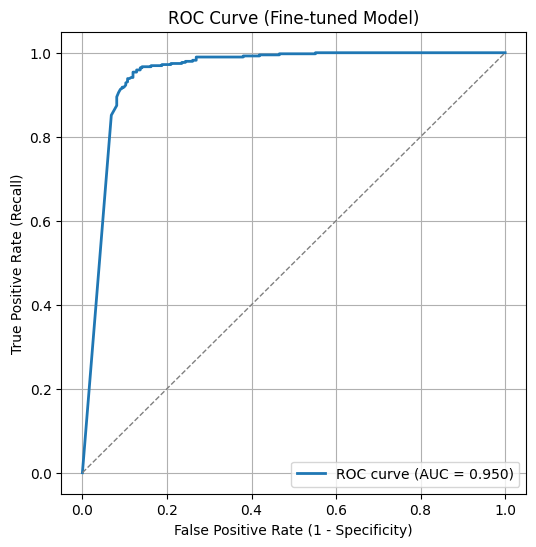

Confusion Matrix [[TN FP],[FN TP]]:
 [[146  88]
 [  4 386]]
              precision    recall  f1-score   support

      Normal       0.97      0.62      0.76       234
   Pneumonia       0.81      0.99      0.89       390

    accuracy                           0.85       624
   macro avg       0.89      0.81      0.83       624
weighted avg       0.87      0.85      0.84       624

AUC: 0.950
Sensitivity (Recall): 0.990
Specificity: 0.624


In [54]:
#예측 확률과 라벨 수집
y_true2, y_pred2 = [], []
for X, y in test.as_numpy_iterator():
    yhat = finetune_model.predict(X, verbose=0).ravel()
    y_true2.extend(y)
    y_pred2.extend(yhat)

y_true2 = np.array(y_true2).ravel().astype(int)
y_pred2 = np.array(y_pred2).ravel()

# ROC, AUC 계산
fpr, tpr, _ = roc_curve(y_true2, y_pred2)
auc = roc_auc_score(y_true2, y_pred2)

# ROC 곡선 그리기
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {auc:.3f})')
plt.plot([0,1],[0,1],'--', lw=1, color='gray')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve (Fine-tuned Model)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# 혼동행렬 및 지표 계산
preds = (y_pred2 >= 0.5).astype(int)
cm = confusion_matrix(y_true2, preds)
tn, fp, fn, tp = cm.ravel()

sensitivity = tp / (tp + fn)  # Recall
specificity = tn / (tn + fp)  # True Negative Rate

# 5) 출력
print("Confusion Matrix [[TN FP],[FN TP]]:\n", cm)
print(classification_report(y_true2, preds, target_names=["Normal","Pneumonia"]))
print(f"AUC: {auc:.3f}")
print(f"Sensitivity (Recall): {sensitivity:.3f}")
print(f"Specificity: {specificity:.3f}")
